<a href="https://colab.research.google.com/github/osimon8/GeoguessrGuessr/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!conda install --file requirements.txt

In [226]:
 %matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt
#import sklearn.ensemble.RandomForestClassifier as RandomForestClassifier
import pandas as pd
import os 
import sys
import geopandas
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import json
import pickle
from torch.utils.data.sampler import Sampler
import random

np.random.seed(0)
torch.manual_seed(0)

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [419]:
def chunk(indices, chunk_size):
    return torch.split(torch.tensor(indices), chunk_size)

'''Returns shuffled samples, but in contiguous groups of 4'''
class IntegrationBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.batch_size = batch_size # - (batch_size % 4)
        self.indices = list(range(len(dataset) // 4))
    
    def __iter__(self):
        random.shuffle(self.indices)
        batches  = chunk(self.indices, self.batch_size // 4)
        combined = [[x for sub in [[4*i, 4*i + 1, 4*i + 2, 4*i + 3] for i in batch.tolist()] for x in sub] for batch in batches]
        random.shuffle(combined)
        return iter(combined)
    
    def __len__(self):
        return 4 * len(self.indices) // self.batch_size

In [443]:
#train_data_directory = '/content/drive/MyDrive/CIS 522/50States500'
train_data_directory = '50States500'
train_data_directory_big = '50States2K'
test_data_directory = '50States100_test'

transform_pipeline = transforms.Compose([transforms.ToTensor(), transforms.Resize((64, 64))])

dataset = datasets.ImageFolder(train_data_directory, transforms.Compose([transforms.ToTensor()]))
train_dataset = datasets.ImageFolder(train_data_directory, transform_pipeline)
train_dataset_big = datasets.ImageFolder(train_data_directory_big, transform_pipeline)
test_dataset = datasets.ImageFolder(test_data_directory, transform_pipeline)
test_dataset_hr = datasets.ImageFolder(test_data_directory, transforms.Compose([transforms.ToTensor()]))

val_dataset = test_dataset
# n = len(dataset)
# train_size = int(0.8*n)


# train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, n - train_size],generator=torch.Generator().manual_seed(42))
#train_dataset = dataset

#validation_dataset = []

batch_size = 40
batch_size_big = 80

data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, num_workers=6)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, pin_memory=torch.cuda.is_available(), shuffle=True)
data_loader_small = torch.utils.data.DataLoader(dataset, batch_size = 4)
data_loader_shuffled = torch.utils.data.DataLoader(dataset, batch_size = 100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, pin_memory=torch.cuda.is_available(), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
test_loader_hr = torch.utils.data.DataLoader(test_dataset_hr, batch_size = batch_size, shuffle=True)

integ_train = IntegrationBatchSampler(train_dataset, batch_size)
integ_test = IntegrationBatchSampler(test_dataset, batch_size)
integ_val = IntegrationBatchSampler(val_dataset, batch_size)

train_data_loader_integ = torch.utils.data.DataLoader(train_dataset, pin_memory=torch.cuda.is_available(), batch_sampler=integ_train)
test_data_loader_integ = torch.utils.data.DataLoader(test_dataset, pin_memory=torch.cuda.is_available(), batch_sampler=integ_test)
val_data_loader_integ = torch.utils.data.DataLoader(val_dataset, pin_memory=torch.cuda.is_available(), batch_sampler=integ_val)

integ_train_big = IntegrationBatchSampler(train_dataset_big, batch_size_big)

train_data_loader_integ_big = torch.utils.data.DataLoader(train_dataset_big, pin_memory=torch.cuda.is_available(), batch_sampler=integ_train_big)



In [444]:
train_dataset_big

Dataset ImageFolder
    Number of datapoints: 100000
    Root location: 50States2K
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(64, 64), interpolation=bilinear)
           )

In [7]:
with open('json/state_initials.json') as f:
    initials_to_state = json.load(f) 
state_to_initials = {v: k for k, v in initials_to_state.items()}

In [8]:
# https://gist.github.com/neilb/ee60cd179d5eb17d1cb616cdeeda760f

# adjacency list representation of 50 states
with open('json/state_graph.json') as f:
    state_graph_al = json.load(f) 

In [9]:
# setup cost matrix
state_graph_cost = np.ones((50, 50))
for i in range(50):
    for j in range(50):
        source = state_to_initials[dataset.classes[i]]
        dest = state_to_initials[dataset.classes[j]]
        if source == dest:
            state_graph_cost[i][j] = 0
        elif dest not in state_graph_al[source]['adjacent']:
            state_graph_cost[i][j] = np.inf

# floyd warshall all pairs shortest path
for k in range(50):
    for i in range(50):
        for j in range(50):
            if (state_graph_cost[i, k] + state_graph_cost[k, j] < state_graph_cost[i, j]):
                state_graph_cost[i,j] = state_graph_cost[i, k] + state_graph_cost[k, j]

# set no-paths to cost of 11
for i in range(50):
    for j in range(50):
        if np.isinf(state_graph_cost[i][j]):
            state_graph_cost[i][j] = 11

state_graph_cost = torch.tensor(state_graph_cost, dtype=torch.float32, device=device)
# state = 'Illinois'
# plot_heatmap(state_graph_cost[dataset.class_to_idx[state]] * -1, label=state)

In [10]:
def get_state_data_loader(state, batch_size=100):
    tot = len(train_dataset)
    c = dataset.class_to_idx [state]
    weights = [1e-4 if i // 500 == c else 0 for i in range(tot)]
    sampler = torch.utils.data.WeightedRandomSampler(weights, batch_size)
    return  torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler=sampler)
    
    

## Data Visualization

### Sample set of images
Here we see the four images for a random coordinate sampled from the dataset. The images appear in the order of camera rotation 0, 90, 180, and 270 degrees.

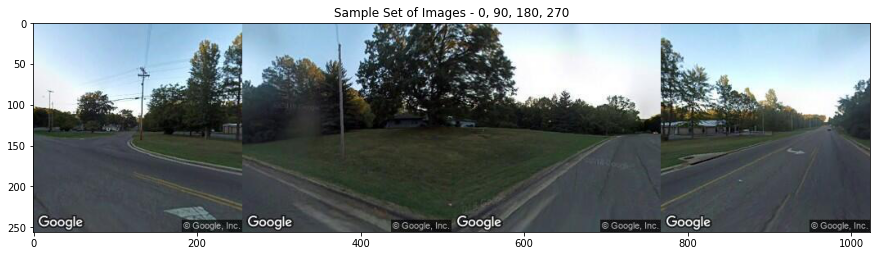

In [11]:
example_batch = next(iter(data_loader_small))[0]
stacked = example_batch[0]
for i in range(1, 4):
    stacked = torch.cat((stacked,example_batch[i]), 2)
    
plt.figure(figsize=(15,10))
plt.title("Sample Set of Images - 0, 90, 180, 270")
plt.imshow(stacked.permute(1, 2, 0))

### Sample image for each state

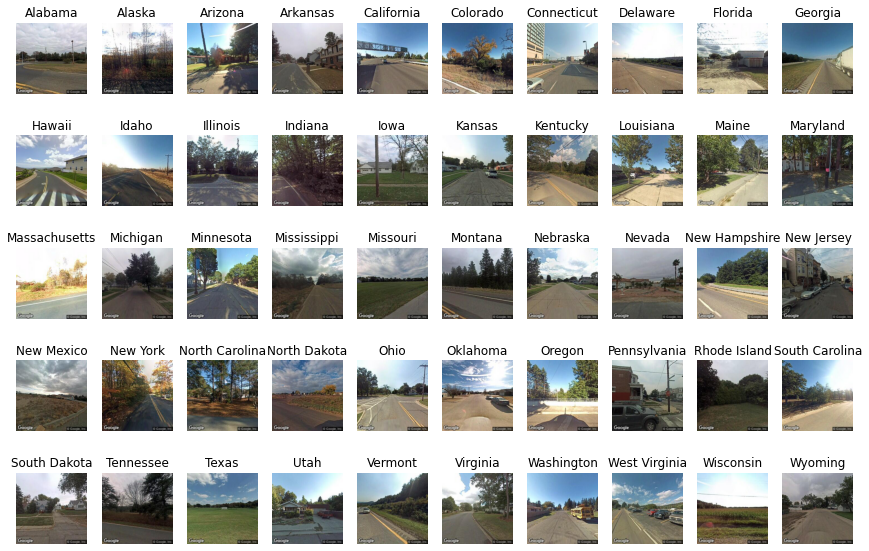

In [12]:
sample_50 = {}
for data, label in data_loader_shuffled:
    for d, l in zip(data, label):
        if l.item() in sample_50.keys():
            continue
        sample_50[l.item()] = d
    if (len(sample_50) == 50):
        break

fig, axs = plt.subplots(5, 10, figsize=(15,10))
for label, im in sorted(sample_50.items()):    
    ax = axs.flat[label] 
    ax.set_title(dataset.classes[label])
    ax.imshow(im.permute(1, 2, 0))
    ax.axis('off')

### Average image and histogram by state 
In this section, we sample some random images for a given state, then average all of those images together and plot a histogram. We can see that for all states we tend towards an image with a gray bottom half and a bluish top half, indicating that our average image looks at the road with the sky above it. Sampling a smaller number of images is a little bit more informative; we can start to make out that more rural states tend to have more trees visible and urban states have more gray color overall.

In [13]:
def collect_state_data(desired_states, num = 10):
    results = {state: [] for state in desired_states }

    for state in desired_states:
        loader = get_state_data_loader(state, batch_size = num)
        for data, _ in loader:
            results[state].extend(data)
            
    return results

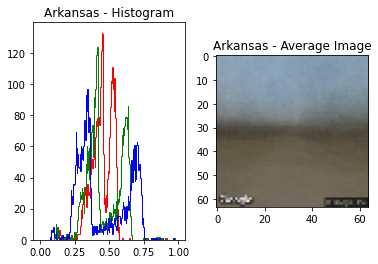

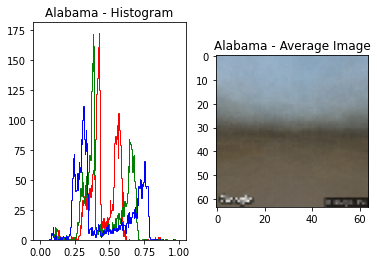

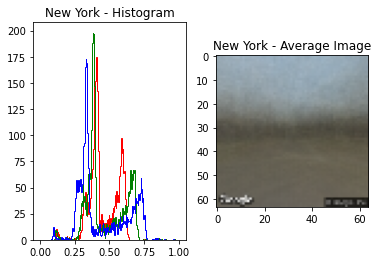

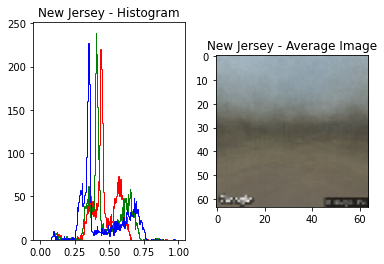

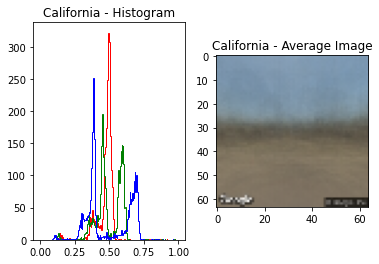

In [14]:
desired_states = ['Arkansas', 'Alabama', 'New York', 'New Jersey', 'California']
num_images = 100

state_data = collect_state_data(desired_states, num=num_images)
means = {}
colors = ['red', 'green', 'blue']

for state in desired_states:
    tens = torch.stack(state_data[state])
    mean = torch.mean(tens, dim=0).permute(1, 2, 0)
    fig = plt.figure()
    plt.axis('off')

    fig.add_subplot(121)
    plt.title('{} - Histogram'.format(state))
    for i in range(3):
        plt.hist(mean.numpy()[:, :, i].ravel(), bins=256, range=(0.0, 1.0), histtype='step', color=colors[i])
    
    fig.add_subplot(122)
    plt.title('{} - Average Image'.format(state))
    plt.imshow(mean)
    
    plt.show()

In [513]:
states = geopandas.read_file('map_data/States_shapefile.shp')
states = states[states['State_Name'] != 'DISTRICT OF COLUMBIA']
states = states.to_crs("EPSG:3395")
states_contig = states[states['State_Name'] != 'HAWAII']
states_contig = states_contig[states_contig['State_Name'] != 'ALASKA']

def get_state_geo(state):
    return states[states['State_Name'] == state]  

def plot_heatmap(probs, label=None, im = None, title=None):
    vmin = np.min(probs)
    vmax = np.max(probs)
    if im is not None:
        plt.title('Test Image')
        plt.imshow(im)
    cmap = 'YlOrRd'
    ak_index = dataset.class_to_idx["Alaska"]
    hi_index = dataset.class_to_idx["Hawaii"]
    plt.figure(figsize=(18, 12))
    if title is None:
        if label is not None:
            plt.title("Image True Label: {}".format(label))
    else:
        plt.title(title)
    ax = plt.gca()
    us_boundary_map = states_contig.boundary.plot(ax=ax, color='Black', linewidth=1)
    probs_sliced = []
    for i in range(50):
        if i != hi_index and i != ak_index:
            probs_sliced.append(probs[i])
    us_map = states_contig.plot(column=np.array(probs_sliced) , ax=us_boundary_map, cmap=cmap, 
                                vmin=vmin, vmax=vmax, legend=True, linewidth=4)
    us_map.axis('off')
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    hawaii = get_state_geo('HAWAII')
    hi_boundary_map = hawaii.boundary.plot(figsize=(1, 1), ax=ax1, color='Black', linewidth=1)
    hawaii_map = hawaii.plot(column=np.array([probs[hi_index]]) , ax=hi_boundary_map, cmap=cmap, 
                             vmin=vmin, vmax=vmax, linewidth=4)
    hawaii_map.axis('off')
    alaska = get_state_geo('ALASKA')
    ak_boundary_map = alaska.boundary.plot(figsize=(4, 4), ax=ax2, color='Black', linewidth=1)
    alaska_map = alaska.plot(column=np.array([probs[ak_index]]) , ax=ak_boundary_map, cmap=cmap,
                             vmin=vmin, vmax=vmax, linewidth=4)
    alaska_map.axis('off')
    plt.figure()
    

In [16]:
dataframe = pd.DataFrame()

ctr = 0

# for data, label in data_loader:
#     num = data.numpy()
#     dataframe.append(num)
#     ctr += 1
#     if (ctr > 1000):
#         break
    #dataframe.insert()


In [17]:
#print(train_dataset.imgs[:1000])

In [38]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier()

'''randomForest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False) '''





"randomForest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n           max_depth=None, max_features='auto', max_leaf_nodes=None,\n           min_impurity_split=1e-07, min_samples_leaf=1,\n           min_samples_split=2, min_weight_fraction_leaf=0.0,\n           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,\n           verbose=0, warm_start=False) "

In [39]:
from sklearn.metrics import accuracy_score

rf_data_size = 10000

data_loader_all = torch.utils.data.DataLoader(train_dataset, batch_size = rf_data_size, shuffle=True)
(X,y) = next(iter(data_loader_all))

In [40]:
print(X.shape)
X = X.reshape(rf_data_size, -1)


torch.Size([10000, 3, 64, 64])


In [41]:
randomForest.fit(X,y)

RandomForestClassifier()

In [42]:
from sklearn.metrics import accuracy_score
X_test, y_test = next(iter(test_loader))


In [43]:
X_test = X_test.reshape(batch_size, -1)
preds = randomForest.predict(X_test)
print("Accuracy:", accuracy_score(y_test,preds))

Accuracy: 0.06666666666666667


In [24]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 64, 3, 1)
        self.conv5 = nn.Conv2d(64, 32, 3, 1)
#         self.conv1 = nn.Conv2d(3, 32, 2, 1)
#         self.conv2 = nn.Conv2d(32, 64, 2, 1)
#         self.conv3 = nn.Conv2d(64, 128, 2, 1)
#         self.conv4 = nn.Conv2d(128, 64, 2, 1)
#         self.conv5 = nn.Conv2d(64, 32, 3, 1)
#         self.fc1 = nn.Linear(288, 128)
#         self.fc2 = nn.Linear(128, 50)
        self.fc_alt_1 = nn.Linear(256, 128)
        self.fc_alt_2 = nn.Linear(128, 50)
#         self.fc_alt_1 = nn.Linear(2304, 1000)
#         self.fc_alt_2 = nn.Linear(1000, 50)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)
        x = self.dropout(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)
        #x = self.conv5(x)
        #x = F.relu(x)
        #x = F.max_pool2d(x, 3)
        x = torch.flatten(x, 1)
#         print(x.shape)
        x = self.fc_alt_1(x)
        x = F.relu(x)
        x = self.fc_alt_2(x)
       
        return x

In [390]:
class IntegrationNet(nn.Module):
    def __init__(self):
        super(IntegrationNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 64, 3, 1)
        self.conv5 = nn.Conv2d(64, 32, 3, 1)
        self.fc_alt_1 = nn.Linear(1024, 512)
        self.fc_alt_2 = nn.Linear(512, 50)
        self.dropout = nn.Dropout()
#         self.weight = torch.ones(batch_size, self.small_batch, 1).to(device)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)
        x = self.dropout(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)
        bs = x.shape[0] // 4
        x = torch.flatten(x)
        # chunk into groups of four before linear layers
        x = x.view(bs, -1)
        x = self.fc_alt_1(x)
        x = F.relu(x)
        x = self.fc_alt_2(x)
        o = torch.ones(x.shape[0] * 4, x.shape[1], requires_grad=True).to(device)
        # i'm sure theres a better way to do this but idk what it is
        for i in range(x.shape[0]):
            t = x[i]
            i *= 4
            o[i] = t
            o[i+1] = t
            o[i+2] = t 
            o[i+3] = t 

        return o

In [302]:
class DistanceWeightedCrossEntropyLoss(nn.Module):
    ce = nn.CrossEntropyLoss()

    def __init__(self):
        super().__init__()
        self.log_softmax = nn.Softmax(dim=1)
        
    def forward(self, x, y):
        log_probabilities = self.log_softmax(x)
        dists = (log_probabilities @ state_graph_cost).gather(1, y.view(y.shape[0], 1))
        return torch.mean(dists) * self.ce(x, y)
    
    

In [434]:
def train(model, device, train_loader, validation_loader, epochs, basis=([], [], [], [])):

#     criterion = DistanceWeightedCrossEntropyLoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                              lr=0.01, momentum=0.9)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    train_loss, train_acc, validation_loss, validation_acc = basis
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 
        for data, target in train_loader:
            # this can be done async if using gpu
            target = target.to(device, non_blocking=torch.cuda.is_available())
            data = data.to(device)

                # add micro for coding training loop
            optimizer.zero_grad()
            output = model(data)
                
            loss = criterion(output, target)
#             print(loss)
            loss.backward()
            optimizer.step()
            #tepoch.set_postfix(loss=loss.item())
            running_loss += loss.item()

            # get accuracy 
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        l = running_loss/len(train_loader)
        train_loss.append(l)
        train_acc.append(correct/total)
        e = epoch + 1
        if (True or e %10 == 0):
            print('Epoch {} Loss: {}'.format(e, l))
                
        # evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        
        with torch.no_grad():
            for data, target in validation_loader:
                # this can be done async if using gpu
                target = target.to(device, non_blocking=torch.cuda.is_available())
                data = data.to(device)
            
                output = model(data)
                
                loss = criterion(output, target)
                #tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
            validation_loss.append(running_loss/len(validation_loader))
            validation_acc.append(correct/total)
    
    return train_loss, train_acc, validation_loss, validation_acc 



In [27]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

In [28]:
# from tqdm.notebook import tqdm, trange


In [520]:
# net = Net1().to(device)
# net = IntegrationNet().to(device)
# print(net)
graphs = (train_loss, train_acc, validation_loss, validation_acc)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_data_loader_integ_big, val_data_loader_integ, 10, basis=graphs)
# charts = (train_loss, train_acc, validation_loss, validation_acc)
# train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_data_loader, validation_loader, 30)

# train_loss1, train_acc1, validation_loss1, validation_acc1 = (train_loss[1:], train_acc[1:], validation_loss[1:], validation_acc[1:])


Epoch 1 Loss: 2.4643653529167175
Epoch 2 Loss: 2.3863186223983766
Epoch 3 Loss: 2.2704357155799864
Epoch 4 Loss: 2.235054207134247
Epoch 5 Loss: 2.159647219467163
Epoch 6 Loss: 2.1250287143230437
Epoch 7 Loss: 2.0413920679569246
Epoch 8 Loss: 1.9959125963687896
Epoch 9 Loss: 1.94240625872612
Epoch 10 Loss: 1.9539017881393432


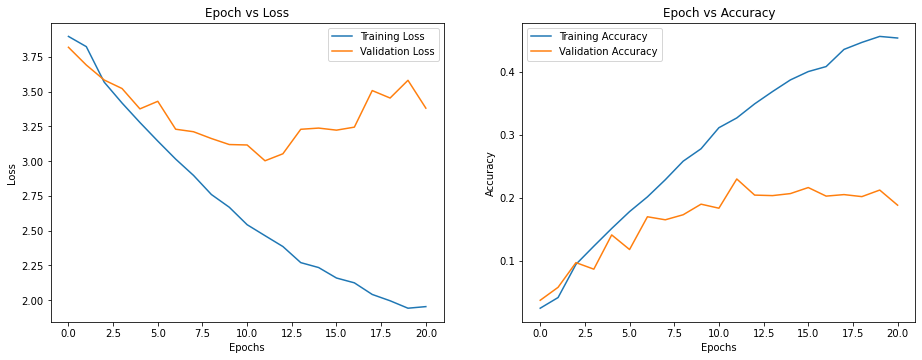

In [521]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [510]:
def save_model(model, filename, train_loss=None, train_acc=None, validation_loss=None, validation_acc=None):
    base = 'trained_models/{}/'.format(filename)
    if not os.path.exists(base):
        os.makedirs(base)
    torch.save(model.state_dict(), base + filename)
    if train_loss is not None:
        with open(base + 'train_loss.pkl', 'wb') as f:
            pickle.dump(train_loss, f)
    if train_acc is not None:
        with open(base + 'train_acc.pkl', 'wb') as f:
            pickle.dump(train_acc, f)
    if validation_loss is not None:
        with open(base + 'validation_loss.pkl', 'wb') as f:
            pickle.dump(validation_loss, f)
    if validation_acc is not None:
        with open(base + 'validation_acc.pkl', 'wb') as f:
            pickle.dump(validation_acc, f)
    

save_model(net, '10i2', train_loss=train_loss, train_acc=train_acc, validation_loss=validation_loss, validation_acc=validation_acc)

In [518]:
def load_model(filename, integ=False, load_graphs=False):
    if integ:
        model = IntegrationNet()
    else:
        model = Net1()
    base = 'trained_models/{}/'.format(filename)
    model.load_state_dict(torch.load(base + filename))
    model.eval()
    if load_graphs:
        with open(base + 'train_loss.pkl', 'rb') as f:
            t_loss = pickle.load(f)
        with open(base + 'train_acc.pkl', 'rb') as f:
            t_acc = pickle.load(f)
        with open(base + 'validation_loss.pkl', 'rb') as f:
            v_loss = pickle.load(f)
        with open(base + 'validation_acc.pkl', 'rb') as f:
            v_acc = pickle.load(f)
        ret = (model.to(device), t_loss, t_acc, v_loss, v_acc)
    else:
        ret = model.to(device)
    return ret

net, train_loss, train_acc, validation_loss, validation_acc = load_model('10i2', integ=True, load_graphs=True)

In [522]:
total = 5000 # 50 states * 100 images per state
acc_by_state = np.array([0] * 50)
t5_acc_by_state = np.array([0] * 50)

for data, label in test_data_loader_integ:
    o = net.forward(data.to(device))
#     print(label)
    smax = F.softmax(o, dim = 1)
#     print(smax)
    _, pred = torch.topk(smax, 5, dim=1, sorted=True)
    pred = pred.detach().cpu()
    for i, l in enumerate(label):
        e = pred[i]
        if l in e:
            t5_acc_by_state[l] += 1
        if l == e[0]:
            acc_by_state[l] += 1
        


test_acc = np.sum(acc_by_state) / total
acc_by_state = acc_by_state / 100 # / state_total

t5_test_acc = np.sum(t5_acc_by_state) / total
t5_acc_by_state = t5_acc_by_state / 100 # / state_total


In [471]:
def plot_acc_by_state(accs, sorted=True, title=None, show_avg=True, k=0):
    states = np.array([state_to_initials[c] for c in dataset.classes])
    if sorted:
        idx = np.argsort(-accs)
        states = states[idx]
        accs = accs[idx]
    plt.figure(figsize=(17,10))
    plt.bar(states, accs)
    ylab = 'Test Accuracy'
    if show_avg:
        avg = np.mean(accs)
        plt.hlines(avg, states[0], states[-1], label=f'Average: {np.round(avg, 3)}', linestyles='dashed', colors=['red'])
    if k > 0:
        ylab = f'Test Accuracy - Top {k}'
        baseline = 0.02 * k
        plt.hlines(baseline, states[0], states[-1], label=f'Random Chance Baseline: {np.round(baseline, 3)}', linestyles='dashed', colors=['cyan'])
    if k > 0 or show_avg:
        plt.legend()
    if title is not None:
        plt.title(title)
    plt.ylabel(ylab)
    plt.show()

Test Accuracy: 0.188
[0.28 0.24 0.08 0.04 0.28 0.16 0.04 0.12 0.12 0.16 1.   0.32 0.04 0.32
 0.16 0.16 0.04 0.04 0.16 0.04 0.32 0.   0.24 0.16 0.   0.32 0.08 0.48
 0.24 0.12 0.28 0.08 0.12 0.12 0.08 0.28 0.24 0.16 0.2  0.12 0.2  0.08
 0.04 0.24 0.56 0.08 0.04 0.32 0.16 0.24]


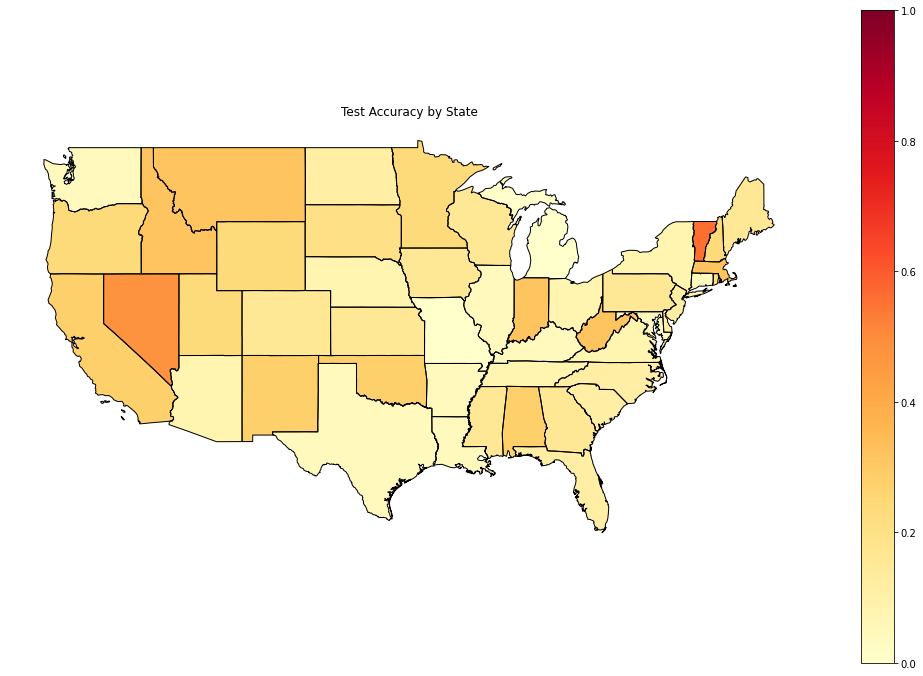

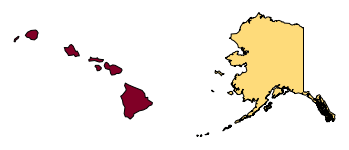

<Figure size 432x288 with 0 Axes>

In [523]:
print('Test Accuracy: {}'.format(test_acc))
print(acc_by_state)
# print(np.mean(acc_by_state))

plot_heatmap(acc_by_state,title="Test Accuracy by State")

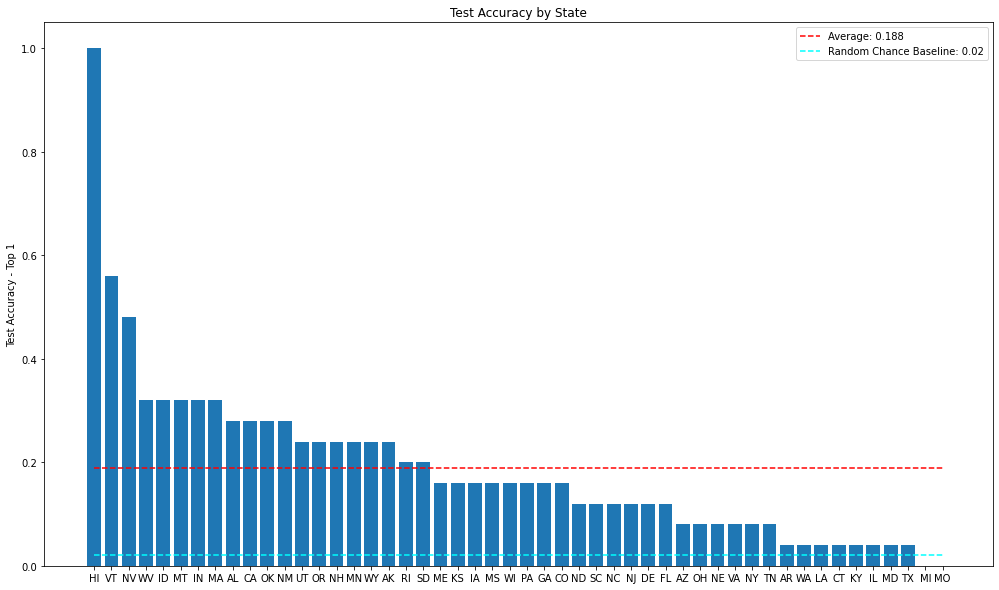

In [524]:
plot_acc_by_state(acc_by_state, title='Test Accuracy by State', k=1)

Test T5 Accuracy: 0.4696
[0.52 0.36 0.48 0.16 0.44 0.48 0.32 0.2  0.44 0.56 1.   0.64 0.28 0.6
 0.56 0.56 0.12 0.44 0.36 0.24 0.48 0.24 0.48 0.48 0.36 0.52 0.48 0.92
 0.48 0.48 0.76 0.44 0.68 0.32 0.36 0.76 0.44 0.32 0.52 0.4  0.52 0.36
 0.28 0.52 0.88 0.4  0.2  0.6  0.44 0.6 ]


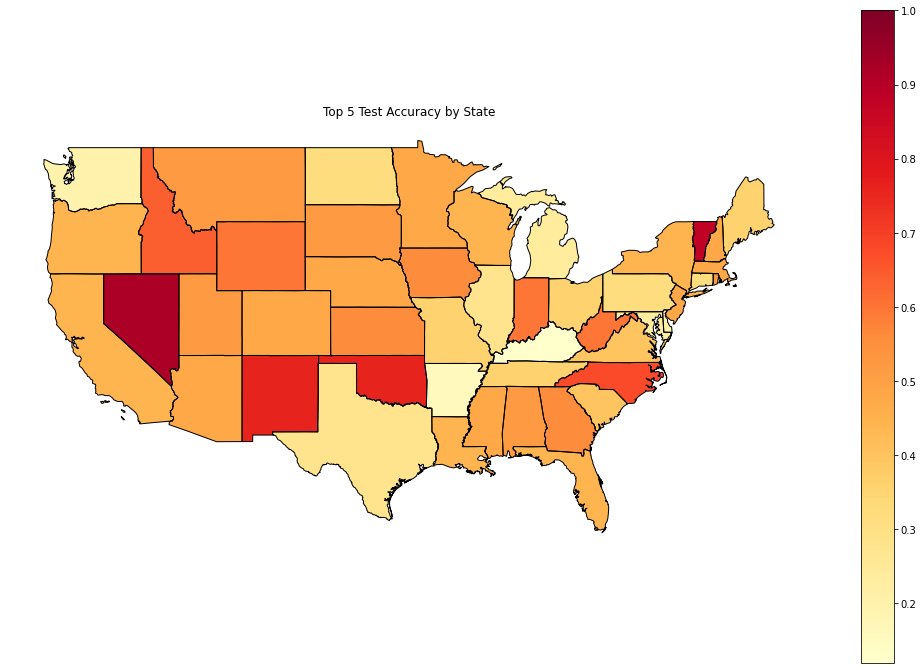

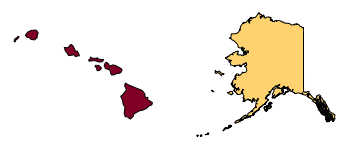

<Figure size 432x288 with 0 Axes>

In [525]:
print('Test T5 Accuracy: {}'.format(t5_test_acc))
print(t5_acc_by_state)
# print(np.mean(t5_acc_by_state))

plot_heatmap(t5_acc_by_state, title='Top 5 Test Accuracy by State')

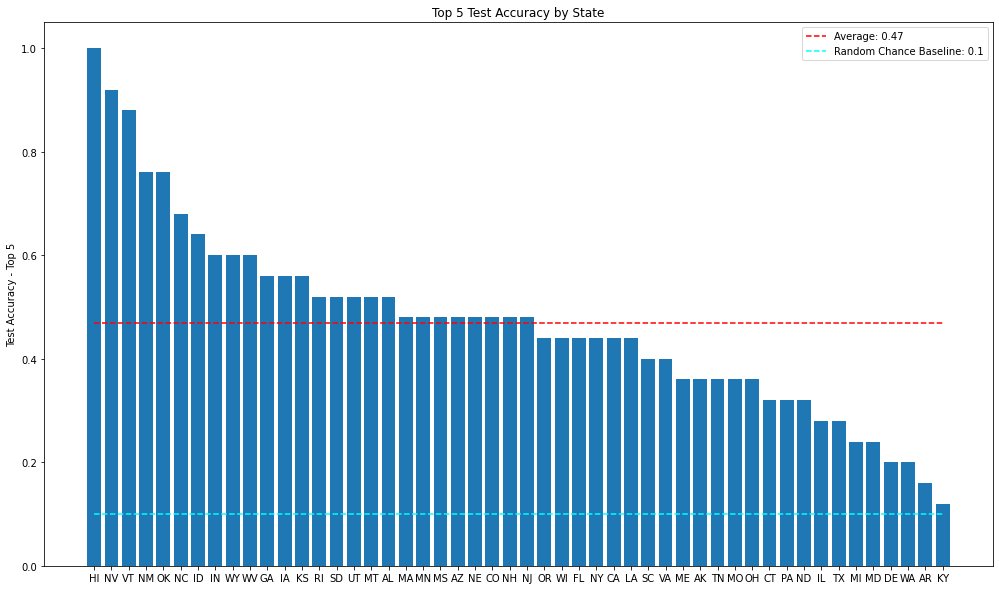

In [526]:
plot_acc_by_state(t5_acc_by_state, title='Top 5 Test Accuracy by State', k =5)

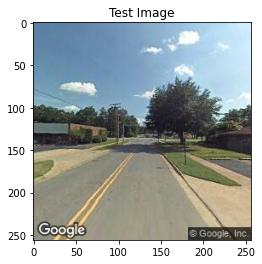

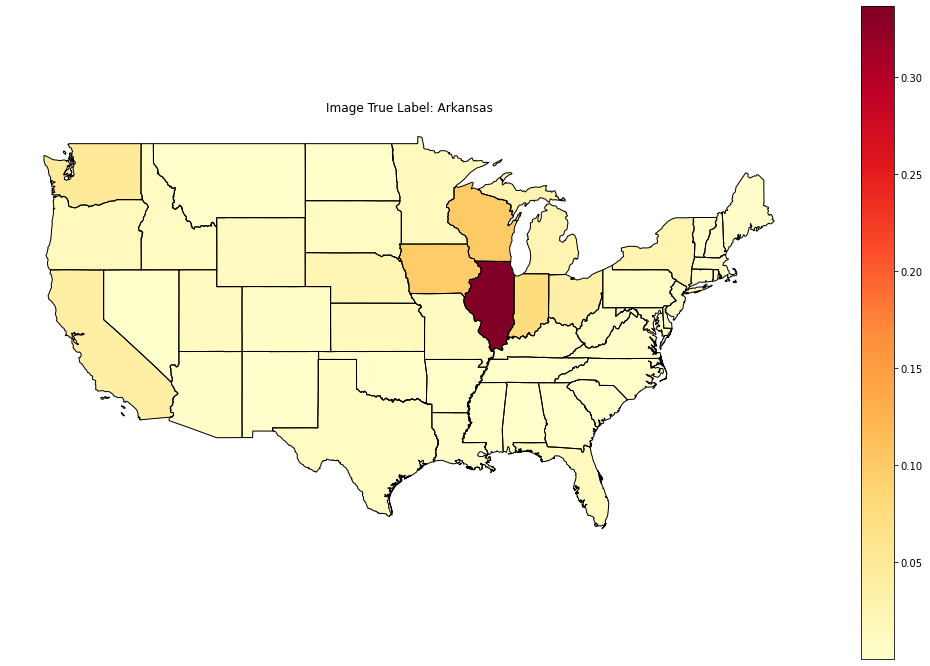

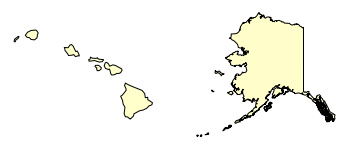

<Figure size 432x288 with 0 Axes>

In [502]:
for data, label in test_loader_hr:
    data_rs = transforms.Resize((64, 64))(data.to(device))
    pred = net.forward(data_rs)
    pred = F.softmax(pred, dim=1)
    #print(pred.shape)
    probs = pred[0].detach().cpu().numpy()
    #print(probs)
    lab = dataset.classes[label[0].item()]
    plot_heatmap(probs, label=lab, im=data[0].permute(1, 2, 0))
    break
    

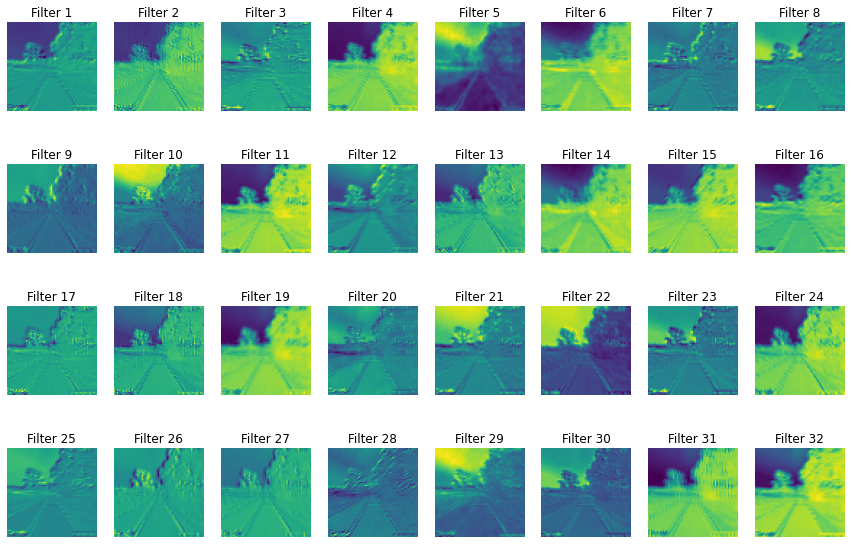

In [225]:
filter1 = net.state_dict()['conv1.weight']
filter1.shape
img = next(iter(test_loader))[0]
conved = net.conv1(img.cuda()).detach().cpu()
fig, axs = plt.subplots(4, 8, figsize=(15,10))
i  = 1
for f in conved[0]:    
    ax = axs.flat[i - 1] 
    ax.set_title(f'Filter {i}')
    ax.imshow(f)
    ax.axis('off')
    i+= 1
